## Try finding the biggest size of our problem where we don't OOM

In [1]:
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import jax
import os
from tqdm import tqdm
from plotnine import *
jax.devices()

[CpuDevice(id=0)]

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
np.repeat([0,1,2,3,4], 3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])

In [3]:
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
adata_histo = ad.io.read_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st = ad.io.read_h5ad(os.path.join(out_path, "adata_st.h5ad"))

print("Bounds for spatial:", adata_st.obs["x_st"].min(), adata_st.obs["x_st"].max())
print("Bounds for histo:", adata_histo.obs["x_st"].min(), adata_histo.obs["x_st"].max())

Bounds for spatial: 0.5399687750000001 12.622358
Bounds for histo: 0.2563436987169236 12.78336690083907


In [4]:
# Split the data into fractions using the x coordinate, as many as needed
def test_input_size(fractions, adata_src, adata_target, output_path, min_x = 0.25, max_x = 12.8):
    breaks = np.linspace(min_x, max_x, num = fractions + 1)
    adatas_src = [adata_src[(adata_src.obs["x_st"] >= breaks[i]) & (adata_src.obs["x_st"] < breaks[i + 1])] 
                  for i in range(fractions)]
    adatas_target = [adata_target[(adata_target.obs["x_st"] >= breaks[i]) & (adata_target.obs["x_st"] < breaks[i + 1])] 
                  for i in range(fractions)]
    print("Source Adatas:", [ad.shape for ad in adatas_src])
    print("Target Adatas:", [ad.shape for ad in adatas_target])

    for i in range(fractions):
        ad_src = adatas_src[i]
        ad_target = adatas_target[i]
        
        tp = tp = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
        tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")

        tp_areas = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
        tp_areas = tp_areas.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding", joint_attr="brain_area_onehot")
        
        try:
            tp = tp.solve(alpha=1.0, epsilon=1e-3)
            tp.save(os.path.join(output_path, f"opt_transport{str(i)}.pkl"), overwrite = True)
            [x.delete() for x in jax.devices()[0].client.live_buffers()]
            
            tp_areas = tp_areas.solve(alpha=0.7, epsilon=0.5e-2)
            tp_areas.save(os.path.join(output_path, f"opt_transport_fused{str(i)}.pkl"), overwrite = True)
            [x.delete() for x in jax.devices()[0].client.live_buffers()]
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(e)
                print("======================================FAILURE=========================================")
                return False  # OOM Error
            else:
                raise e  # Some other error
    print("breaks used:", breaks)
    return True


In [5]:
output_path = "/p/project1/hai_fzj_bda/koenig8/ot/models/largest_model"

fractions = 6
success = False
while (not success) and (fractions <= 12):  # stop at 12
    fractions += 1
    print(f"===========================================Fractions {fractions}==========================================")
    success = test_input_size(fractions, adata_st, adata_histo, output_path)

fractions

===========================================Fractions 7==========================================
Source Adatas: [(3409, 50), (7199, 50), (9356, 50), (10679, 50), (10117, 50), (5661, 50), (3579, 50)]
Target Adatas: [(4239, 1536), (16830, 1536), (32096, 1536), (41844, 1536), (40559, 1536), (30216, 1536), (24875, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3409, 4239)].                                          
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                        

2025-03-14 11:30:11.785699: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 24.52GiB (26327209211 bytes) by rematerialization; only reduced to 24.81GiB (26635965700 bytes), down from 25.75GiB (27643743980 bytes) originally


WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10679, 41844)].                                        


2025-03-14 11:32:47.456288: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 24.51GiB (26323417051 bytes) by rematerialization; only reduced to 24.57GiB (26382490474 bytes), down from 26.23GiB (28162541630 bytes) originally


WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10117, 40559)].                                        
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10117, 40559)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                           

7

In [6]:
out_text = """
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3409, 4239)].                                          
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3409, 4239)].                                          
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(7199, 16830)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(7199, 16830)].                                         
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(9356, 32096)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(9356, 32096)].                                         
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10679, 41844)].                                        
2025-03-14 11:30:11.785699: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 24.52GiB (26327209211 bytes) by rematerialization; only reduced to 24.81GiB (26635965700 bytes), down from 25.75GiB (27643743980 bytes) originally
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10679, 41844)].                                        
2025-03-14 11:32:47.456288: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 24.51GiB (26323417051 bytes) by rematerialization; only reduced to 24.57GiB (26382490474 bytes), down from 26.23GiB (28162541630 bytes) originally
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10117, 40559)].                                        
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(10117, 40559)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5661, 30216)].                                         
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5661, 30216)].                                         
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3579, 24875)].                                         
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3579, 24875)].    
"""
out_text.count("did not converge")


5

==> 5/12 problems did not converge

# Translate the problems and save them in the same folder

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"]="cpu"

import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem
from plotnine import *

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt
from tqdm import tqdm

import anndata as ad
import scanpy as sc
import jax

jax.devices()

[CpuDevice(id=0)]

In [2]:
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
adata_histo = ad.io.read_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st = ad.io.read_h5ad(os.path.join(out_path, "adata_st.h5ad"))

## Load all problems

In [3]:
fractions = 7
breaks = np.linspace(0.25, 12.8, num = fractions + 1)
path = "/p/project1/hai_fzj_bda/koenig8/ot/models/largest_model"

In [4]:
adatas_src = [adata_st[(adata_st.obs["x_st"] >= breaks[i]) & (adata_st.obs["x_st"] < breaks[i + 1])] 
                  for i in range(fractions)]
adatas_target = [adata_histo[(adata_histo.obs["x_st"] >= breaks[i]) & (adata_histo.obs["x_st"] < breaks[i + 1])] 
              for i in range(fractions)]
print("Adata sample sizes:", [(adatas_src[i].shape[0], adatas_target[i].shape[0]) for i in range(fractions)])

Adata sample sizes: [(3409, 4239), (7199, 16830), (9356, 32096), (10679, 41844), (10117, 40559), (5661, 30216), (3579, 24875)]


## Plot the errors/costs during training

In [5]:
# plot the errors 
tps = []
ftps = []
for i in range(fractions):
    ad_src = adatas_src[i]
    ad_target = adatas_target[i]
    
    tp = tp = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
    tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")
    tp = tp.load(os.path.join(path, f"opt_transport{str(i)}.pkl"))
    tps.append(tp)

    tp_areas = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
    tp_areas = tp_areas.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding", joint_attr="brain_area_onehot")
    tp_areas = tp_areas.load(os.path.join(path, f"opt_transport_fused{str(i)}.pkl"))
    ftps.append(tp_areas)


WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`           

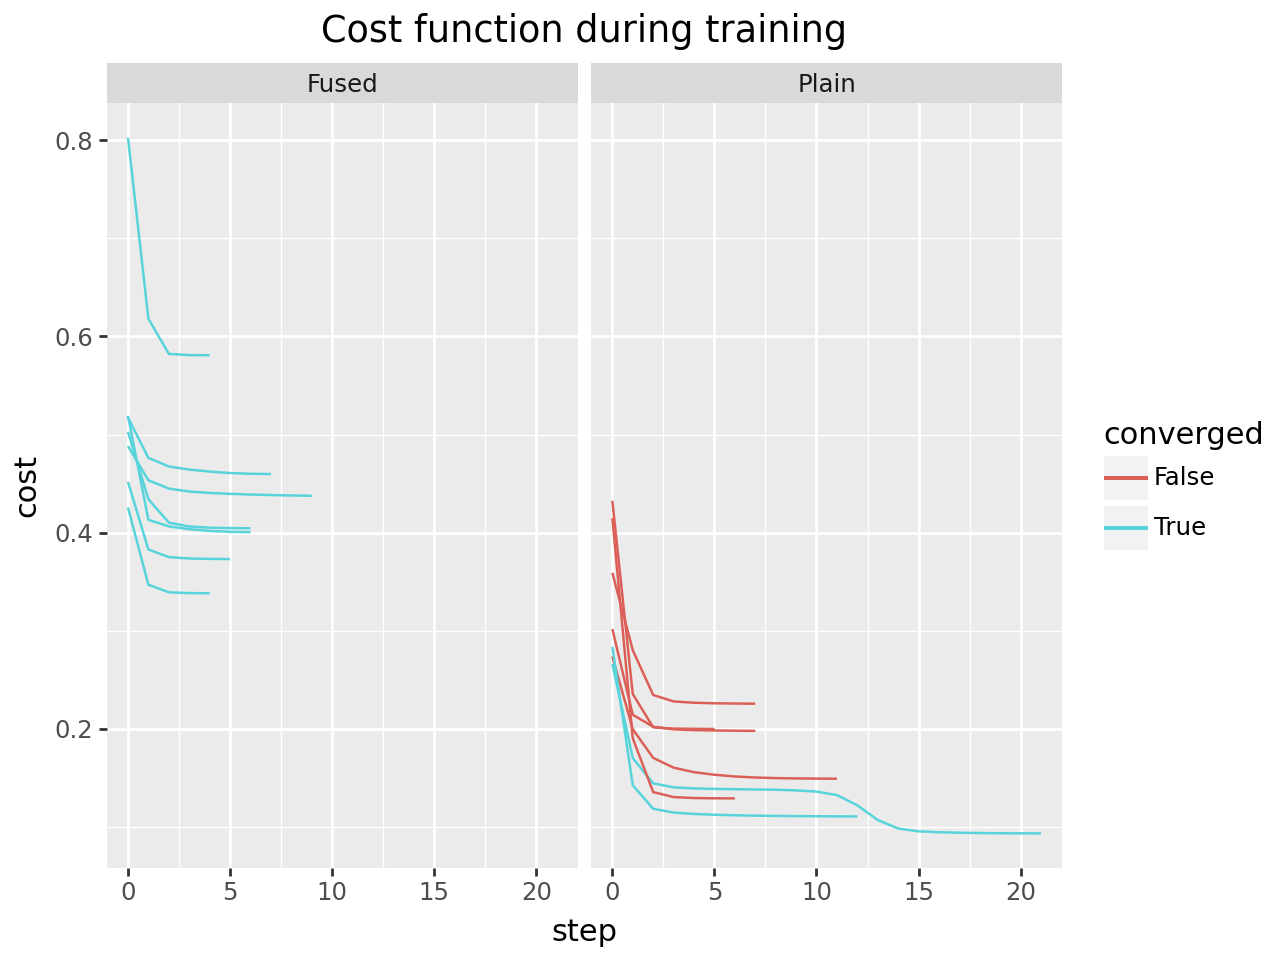

In [15]:
costs = [pd.DataFrame({"cost": p.solutions[('src', 'tgt')]._costs.copy()}) for p in tps]
fcosts = [pd.DataFrame({"cost": p.solutions[('src', 'tgt')]._costs.copy()}) for p in ftps]
costs = [costs[i].assign(converged=bool(tps[i].solutions[('src', 'tgt')]._output.converged))
         .assign(fused = "Plain").assign(step = np.arange(len(costs[i]))).assign(problem=str(i))
    for i in range(len(costs))]
fcosts = [fcosts[i].assign(converged=bool(ftps[i].solutions[('src', 'tgt')]._output.converged))
          .assign(fused = "Fused").assign(step = np.arange(len(fcosts[i]))).assign(problem=str(i))
          for i in range(len(fcosts))]


plot_frame = pd.concat(costs + fcosts, ignore_index = True)
plot_frame = plot_frame[plot_frame.cost != -1]
# Create the plot
plot = (
    ggplot(plot_frame, aes(x="step", y="cost", color="converged", group = "problem")) +
    geom_line() +
    facet_wrap("~fused") +
    labs(title = "Cost function during training")
)

plot

Most of the plain problems without a linear term fail to converge

In [8]:
tp = tps[0]
sol = tp.solutions[('src', 'tgt')]
np.array(sol._output.matrix).shape

(3409, 4239)

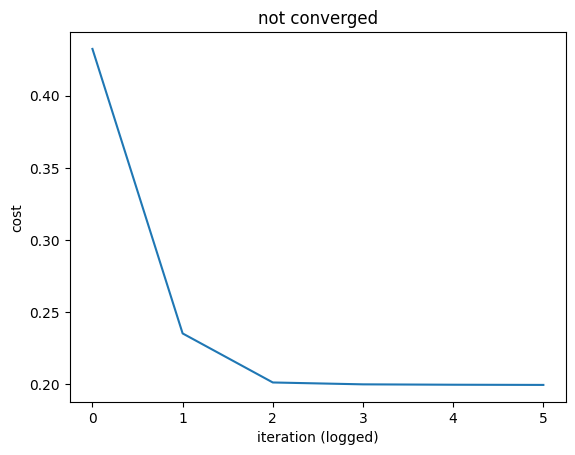

In [14]:
sol.plot_costs()
plt.show()

In [7]:
i = 0
ad_src = adatas_src[i]
ad_target = adatas_target[i]
src = ad_src.obsm["pca_embedding"]
src.shape

(3409, 50)

#### This is how the actual algorithm translates. The goal is to understand what pull does, in order to recreate it using slices of the matrices that fit into memory

In [8]:
def _get_features(
            adata,
            attr,
        ):
    data = getattr(adata, attr["attr"])
    key = attr.get("key")
    return data if key is None else data[key]

src_attr = tp._src_attr
tgt_attr = tp._tgt_attr
features = _get_features(ad_target, attr=tgt_attr)
transformed = tp.translate(source="src", target="tgt", forward=True)
transformed.shape

(3409, 1536)

In [9]:
np.isclose(_get_features(ad_target, attr=tgt_attr), ad_target.obsm["uni_embedding"]).all()

np.True_

In [10]:
prop = tp["src", "tgt"]

In [11]:
rescale_factor = prop.solution._output._rescale_factor
np.isclose(transformed, rescale_factor * (sol._output.matrix @ ad_target.obsm["uni_embedding"])).all()

np.False_

#### => It is not enough to just multiply the matrices
In the paper the push is defined as : T, 𝐵∈ℬ(𝐴), 𝑇#𝜇(𝐵)=𝜇(𝑇−1(𝐵)). //
We need to find the function 𝜇

### From the implementation
#### tp.translate
```
Signature:
tp.translate(
    source: ~K,
    target: ~K,
    forward: bool = True,
    alternative_attr: Optional[Dict[str, Any]] = None,
    **kwargs: Any,
) -> Union[numpy.ndarray[Any, numpy.dtype[numpy.floating]], jax.Array]
Source:   
    def translate(
        self,
        source: K,
        target: K,
        forward: bool = True,
        alternative_attr: Optional[Dict[str, Any]] = None,
        **kwargs: Any,
    ) -> ArrayLike:
        """Translate the source modality to the target modality.

        .. seealso::
            - See :doc:`../../notebooks/tutorials/600_tutorial_translation` on how to translate
              `chromatic accessibility <https://en.wikipedia.org/wiki/ATAC-seq>`_ to
              `gene expression <https://en.wikipedia.org/wiki/Single-cell_sequencing>`_.

        Parameters
        ----------
        source
            Key identifying the source distribution.
        target
            Key identifying the target distribution.
        forward
            If :obj:`True`, translate the ``source`` modality to the ``target`` modality, otherwise vice-versa.
        alternative_attr
            Alternative embedding to translate. Valid option are:

            - :obj:`None` - use the features specified when :meth:`preparing <prepare>` the problem.
            - :class:`str` - key in :attr:`~anndata.AnnData.obsm` where the data is stored.
            - :class:`dict` -  it should contain ``'attr'`` and ``'key'``, the attribute and the key
              in :class:`~anndata.AnnData`.
        kwargs
            Keyword arguments for :meth:`push` or :meth:`pull`, depending on the ``forward``.

        Returns
        -------
        If ``forward = True``, the translation of the ``source`` modality to the ``target`` modality,
        otherwise vice-versa.
        """

        def _get_features(
            adata: AnnData,
            attr: Dict[str, Any],
        ) -> ArrayLike:
            data = getattr(adata, attr["attr"])
            key = attr.get("key")
            return data if key is None else data[key]

        if self._src_attr is None:
            raise ValueError("Source attribute is `None`.")
        if self._tgt_attr is None:
            raise ValueError("Target attribute is `None`.")

        kwargs["scale_by_marginals"] = True
        kwargs["normalize"] = False

        prob = self[source, target]  # type: ignore[index]
        if alternative_attr is None:
            src_attr = self._src_attr
            tgt_attr = self._tgt_attr
        elif isinstance(alternative_attr, str):
            src_attr = tgt_attr = {"attr": "obsm", "key": alternative_attr}
        else:
            src_attr = tgt_attr = alternative_attr

        if forward:
            return prob.pull(_get_features(self.adata_tgt, attr=tgt_attr), **kwargs)

        adata_src = self.adata_src if self.batch_key is None else prob.adata_src
        return prob.push(_get_features(adata_src, attr=src_attr), **kwargs)
```

#### prop.pull()

```
Signature:
prop.pull(
    data: Union[str, numpy.ndarray[Any, numpy.dtype[numpy.floating]], jax.Array, NoneType] = None,
    subset: Union[str, List[str], Tuple[int, int], NoneType] = None,
    normalize: bool = True,
    *,
    split_mass: bool = False,
    scale_by_marginals: bool = False,
) -> Union[numpy.ndarray[Any, numpy.dtype[numpy.floating]], jax.Array]
Source:   
    @require_solution
    def pull(
        self,
        data: Optional[Union[str, ArrayLike]] = None,
        subset: Optional[Union[str, List[str], Tuple[int, int]]] = None,
        normalize: bool = True,
        *,
        split_mass: bool = False,
        scale_by_marginals: bool = False,
    ) -> ArrayLike:
        r"""Pull data through the :attr:`~moscot.base.output.BaseDiscreteSolverOutput.transport_matrix`.

        Parameters
        ----------
        data
            Data to pull through the transport matrix. Valid options are:

            - :class:`~numpy.ndarray` - array of shape ``[m,]`` or ``[m, d]``.
            - :class:`str` - key in :attr:`adata_tgt.obs['{data}'] <adata_tgt>`. If ``subset`` is a :class:`list`,
              the data will be a boolean mask determined by the subset. Useful for categorical data.
            - :obj:`None` - the value depends on the ``subset``.

              - :class:`list` - names in :attr:`adata_tgt.obs_names <adata_tgt>` to pull.
              - :class:`tuple` - start and offset indices :math:`(subset[0], subset[0] + subset[1])`.
                that define a boolean mask to pull.
              - :obj:`None` - uniform array of :math:`1`.
        subset
            Pull values contained only within the subset.
        normalize
            Whether to normalize the columns of ``data`` to sum to :math:`1`.
        split_mass
            Whether to split non-zero values in ``data`` into separate columns.
        scale_by_marginals
            Whether to scale by the target :term`marginals` :attr:`b`.

        Returns
        -------
        The transported values, array of shape ``[n, d]``.
        """
        if TYPE_CHECKING:
            assert isinstance(self.solution, BaseDiscreteSolverOutput)
        data = self._get_mass(self.adata_tgt, data=data, subset=subset, normalize=normalize, split_mass=split_mass)
        return self.solution.pull(data, scale_by_marginals=scale_by_marginals)
```

In [12]:
np.isclose(transformed, prop.pull(features, subset = None, normalize = False, scale_by_marginals = True)).all()

np.True_

In [13]:
np.isclose(transformed[:, :5], prop.pull(features[:, :5], subset = None, normalize = False, scale_by_marginals = True)).all()

np.True_

This can help us pull the data through the matrix w.o running out of memory. We can split the target dimension features into batches. Let's see if it is generally the same for both a fused and a non-fused GW problem

### Try to validate own translate

In [14]:
ftp = ftps[0]
fprop = ftp["src", "tgt"]
ftransformed = ftp.translate(source="src", target="tgt", forward=True)

In [15]:
batch_size = 100
batch_transformed = []
batch_fused_transformed = []
ftp = ftps[0]
fprop = ftp["src", "tgt"]

for i in range(0, features.shape[1], batch_size):
    batch_transformed.append(prop.pull(
        features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
    ))
    batch_fused_transformed.append(fprop.pull(
        features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
    ))

bt = np.concatenate(batch_transformed, axis=1)
bft = np.concatenate(batch_fused_transformed, axis=1)

print("Works for non-fused:", np.isclose(transformed, bt).all())
print("Works for fused:", np.isclose(ftransformed, bft).all())

Works for non-fused: True
Works for fused: True


### Also try for last problem

In [22]:
tp = tps[6]
prop = tp["src", "tgt"]
transformed = tp.translate(source="src", target="tgt", forward=True)

ftp = ftps[6]
fprop = ftp["src", "tgt"]
ftransformed = ftp.translate(source="src", target="tgt", forward=True)

src_attr = tp._src_attr
tgt_attr = tp._tgt_attr
features = _get_features(adatas_target[6], attr=tgt_attr)

In [23]:
batch_size = 600
batch_transformed = []
batch_fused_transformed = []

for i in tqdm(range(0, features.shape[1], batch_size)):
    batch_transformed.append(prop.pull(
        features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
    ))
    batch_fused_transformed.append(fprop.pull(
        features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
    ))

bt = np.concatenate(batch_transformed, axis=1)
bft = np.concatenate(batch_fused_transformed, axis=1)

print("Works for non-fused:", np.isclose(transformed, bt).all())
print("Works for fused:", np.isclose(transformed, bt).all())

100%|██████████| 3/3 [09:35<00:00, 191.73s/it]


XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error preparing computation: Out of memory allocating 546985728000 bytes.

This can fit in memory, but uses up to 370GB / 512GB. So let's try to keep the dimensions for the translate in the ballpark of 600 * 24875 = 15.000.000

### This is equivalent :))
Let's use it to transform our fractioned solutions, but first
## Documentation of tp.translate()

In [33]:
prop._get_mass(prop.adata_tgt, data=_get_features(ad_target, attr=tgt_attr), subset = None, normalize = False).shape

(4239, 1536)

### prop.solution.pull()
```
def pull(self, x: ArrayLike, scale_by_marginals: bool = False) -> ArrayLike:
        """Pull mass through the :attr:`transport_matrix`.

        It is equivalent to :math:`T x` but without instantiating the transport matrix :math:`T`, if possible.

        Parameters
        ----------
        x
            Array of shape ``[m,]`` or ``[m, d]`` to pull.
        scale_by_marginals
            Whether to scale by the target marginals :attr:`b`.

        Returns
        -------
        Array of shape ``[n,]`` or ``[n, d]``, depending on the shape of ``x``.
        """
        if x.ndim not in (1, 2):
            raise ValueError(f"Expected 1D or 2D array, found `{x.ndim}`.")
        if x.shape[0] != self.shape[1]:
            raise ValueError(f"Expected array to have shape `({self.shape[1]}, ...)`, found `{x.shape}`.")
        if scale_by_marginals:
            x = self._scale_by_marginals(x, forward=False)
        return self._apply(x, forward=False)
```

#### prop.solution._apply()
```
def _apply(self, x: ArrayLike, *, forward: bool) -> ArrayLike:
        if x.ndim == 1:
            return self._output.apply(x, axis=1 - forward)
        return self._output.apply(
            x.T,
            axis=1 - forward,
        ).T  # convert to batch first
```

#### prop.solution._output.apply()
```
def apply(self, inputs: jnp.ndarray, axis: int = 0) -> jnp.ndarray:
    """Apply the transport to an array; axis=1 for its transpose."""
    return self._rescale_factor * self.linear_state.apply(inputs, axis=axis)
```
#### prop.solution._output.linear_state.apply()
```
def apply(
      self,
      inputs: jnp.ndarray,
      axis: int = 0,
      lse_mode: bool = True
  ) -> jnp.ndarray:
    """Apply the transport to a ndarray; axis=1 for its transpose."""
    geom = self.ot_prob.geom
    if lse_mode:
      return geom.apply_transport_from_potentials(
          self.f, self.g, inputs, axis=axis
      )
    u = geom.scaling_from_potential(self.f)
    v = geom.scaling_from_potential(self.g)
    return geom.apply_transport_from_scalings(u, v, inputs, axis=axis)
```

#### prop.solution._output.linear_state.ot_prob.geom.apply_transport_from_potentials
```
def apply_transport_from_potentials(
      self,
      f: jnp.ndarray,
      g: jnp.ndarray,
      vec: jnp.ndarray,
      axis: int = 0
  ) -> jnp.ndarray:
    """Apply transport matrix computed from potentials to a (batched) vec.

    This approach does not instantiate the transport matrix itself, but uses
    instead potentials to apply the transport using apply_lse_kernel, therefore
    guaranteeing stability and lower memory footprint.

    Computations are done in log space, and take advantage of the
    (b=..., return_sign=True) optional parameters of logsumexp.

    Args:
      f: jnp.ndarray [num_a,] , potential of size num_rows of cost_matrix
      g: jnp.ndarray [num_b,] , potential of size num_cols of cost_matrix
      vec: jnp.ndarray [batch, num_a or num_b], vector that will be multiplied
        by transport matrix corresponding to potentials f, g, and geom.
      axis: axis to differentiate left (0) or right (1) multiply.

    Returns:
      ndarray of the size of vec.
    """
    if vec.ndim == 1:
      return self._apply_transport_from_potentials(
          f, g, vec[jnp.newaxis, :], axis
      )[0, :]
    return self._apply_transport_from_potentials(f, g, vec, axis)
```

#### prop.solution._output.linear_state.ot_prob.geom._apply_transport_from_potentials
```
def _apply_transport_from_potentials(
      self, f: jnp.ndarray, g: jnp.ndarray, vec: jnp.ndarray, axis: int
  ) -> jnp.ndarray:
    """Apply lse_kernel to arbitrary vector while keeping track of signs."""
    lse_res, lse_sgn = self.apply_lse_kernel(
        f, g, self.epsilon, vec=vec, axis=axis
    )
    lse_res += f if axis == 1 else g
    return lse_sgn * jnp.exp(lse_res / self.epsilon)
```

data = prop._get_mass(prop.adata_tgt, ad_target.obsm["uni_embedding"], subset = None, normalize = False)
data = prop.solution._scale_by_marginals(data, forward = False)
geom = prop.solution._output.linear_state.ot_prob.geom

lse_res, lse_sgn = geom.apply_lse_kernel(
        prop.solution._output.linear_state.f, 
        prop.solution._output.linear_state.g, 
        geom.epsilon, vec=data.T, axis=1
    )
lse_res, lse_sgn

In [37]:
np.isclose(prop.solution._output._rescale_factor * (prop.solution._output.matrix @ data), transformed).sum()

np.int64(0)

# Translate solutions batch-wise

In [ ]:
translation_path = "/p/project1/hai_fzj_bda/koenig8/ot/models/largest_model_translations"
translations = []
translations_fused = []
batch_size = 32

for i in range(fractions):
    if i < 3:
        continue
    print(f"====================================Fraction: {i}====================================")
    ad_target = adatas_target[i]
    features = ad_target.obsm["uni_embedding"]
    print("Input shape:", features.shape)
    
    tp = tps[i]
    prop = tp["src", "tgt"]
    batch_transformed = []

    ftp = ftps[i]
    fprop = ftp["src", "tgt"]
    batch_fused_transformed = []
    
    for j in tqdm(range(0, features.shape[1], batch_size)):
        batch_transformed.append(prop.pull(
            features[:, j:j + batch_size], subset = None, normalize = False, scale_by_marginals = True
        ))

    bt = np.concatenate(batch_transformed, axis=1)
    print("Translation shape:", bt.shape)
    
    for j in tqdm(range(0, features.shape[1], batch_size)):
        batch_fused_transformed.append(fprop.pull(
            features[:, j:j + batch_size], subset = None, normalize = False, scale_by_marginals = True
        ))

    bft = np.concatenate(batch_fused_transformed, axis=1)
    print("Fused Translation shape:", bft.shape)

    translations.append(bt)
    np.save(os.path.join(translation_path, f"translation_{i}.npy"), bt)
    translations_fused.append(bft)
    np.save(os.path.join(translation_path, f"translations_fused_{i}.npy"), bft)

====================================Fraction: 3====================================
Input shape: (41844, 1536)


100%|██████████| 48/48 [12:07<00:00, 15.17s/it]


Translation shape: (10679, 1536)


100%|██████████| 48/48 [10:38<00:00, 13.30s/it]


Fused Translation shape: (10679, 1536)
====================================Fraction: 4====================================
Input shape: (40559, 1536)


100%|██████████| 48/48 [09:52<00:00, 12.35s/it]


Translation shape: (10117, 1536)


100%|██████████| 48/48 [10:00<00:00, 12.51s/it]


Fused Translation shape: (10117, 1536)
====================================Fraction: 5====================================
Input shape: (30216, 1536)


100%|██████████| 48/48 [04:20<00:00,  5.44s/it]


Translation shape: (5661, 1536)


 19%|█▉        | 9/48 [00:45<03:35,  5.51s/it]

### Save the translations as one big npy as well as in an adata

In [15]:
translation_path = "/p/project1/hai_fzj_bda/koenig8/ot/models/largest_model_translations"
translations = list(range(fractions))
translations_fused = list(range(fractions))

for f in os.listdir(translation_path):
    filepath = os.path.join(translation_path, f)
    if f.startswith("translation_"):
        i = int(f.split("_")[1].split(".")[0])
        translations[i] = np.load(filepath)
    elif f.startswith("translations"):
        i = int(f.split("_")[2].split(".")[0])
        translations_fused[i] = np.load(filepath)

print(len(translations), len(translations_fused))
[(translations[i].shape, translations_fused[i].shape) for i in range(fractions)]

7 7


[((3409, 1536), (3409, 1536)),
 ((7199, 1536), (7199, 1536)),
 ((9356, 1536), (9356, 1536)),
 ((10679, 1536), (10679, 1536)),
 ((10117, 1536), (10117, 1536)),
 ((5661, 1536), (5661, 1536)),
 ((3579, 1536), (3579, 1536))]

In [17]:
translations_c = np.concatenate(translations, axis = 0)
fused_translations_c = np.concatenate(translations_fused, axis = 0)
translations_c.shape, fused_translations_c.shape, adata_st.obsm["pca_embedding"].shape

((50000, 1536), (50000, 1536), (50000, 50))

In [18]:
np.save(os.path.join(translation_path, "full_translation.npy"), translations_c)
np.save(os.path.join(translation_path, "full_translations_fused.npy"), fused_translations_c)

In [26]:
# Store in adata
adata_st.obsm["translation"] = translations_c
adata_st.obsm["translation_fused"] = fused_translations_c

# Assign where the breaks were made
breaks_st = []
breaks_histo = []

counter = 0
for ad in adatas_src:
    breaks_st.append(np.repeat(counter, ad.shape[0]))
    counter += 1
adata_st.obs["fraction"] = np.concatenate(breaks_st, axis = 0)

counter = 0
for ad in adatas_target:
    breaks_histo.append(np.repeat(counter, ad.shape[0]))
    counter += 1
adata_histo.obs["fraction"] = np.concatenate(breaks_histo, axis = 0)

# Look at overall results

## UMAP

In [27]:
adata = sc.concat(
    [adata_st, adata_histo],
    join="outer",
    label="batch",
    keys=["ST (translated)", "Histo"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translations_c, adata_histo.obsm["uni_embedding"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


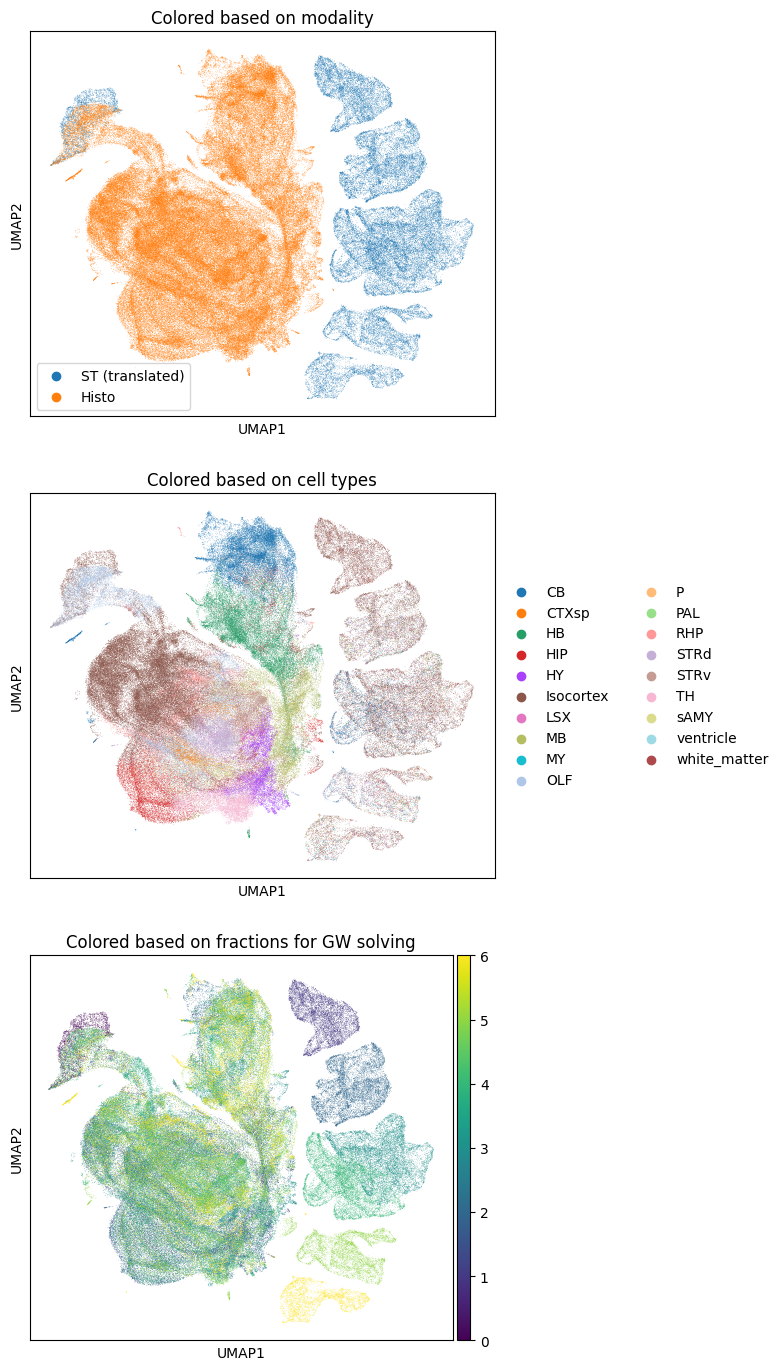

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 17))

sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")

sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")

sc.pl.umap(adata, color=["fraction"], ax=ax3, show=False)
ax3.set_title("Colored based on fractions for GW solving")
# plt.tight_layout(pad=3.0)
plt.show()

In [32]:
adata.obsm["X_translated_2"] = np.concatenate(
    (fused_translations_c, adata_histo.obsm["uni_embedding"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

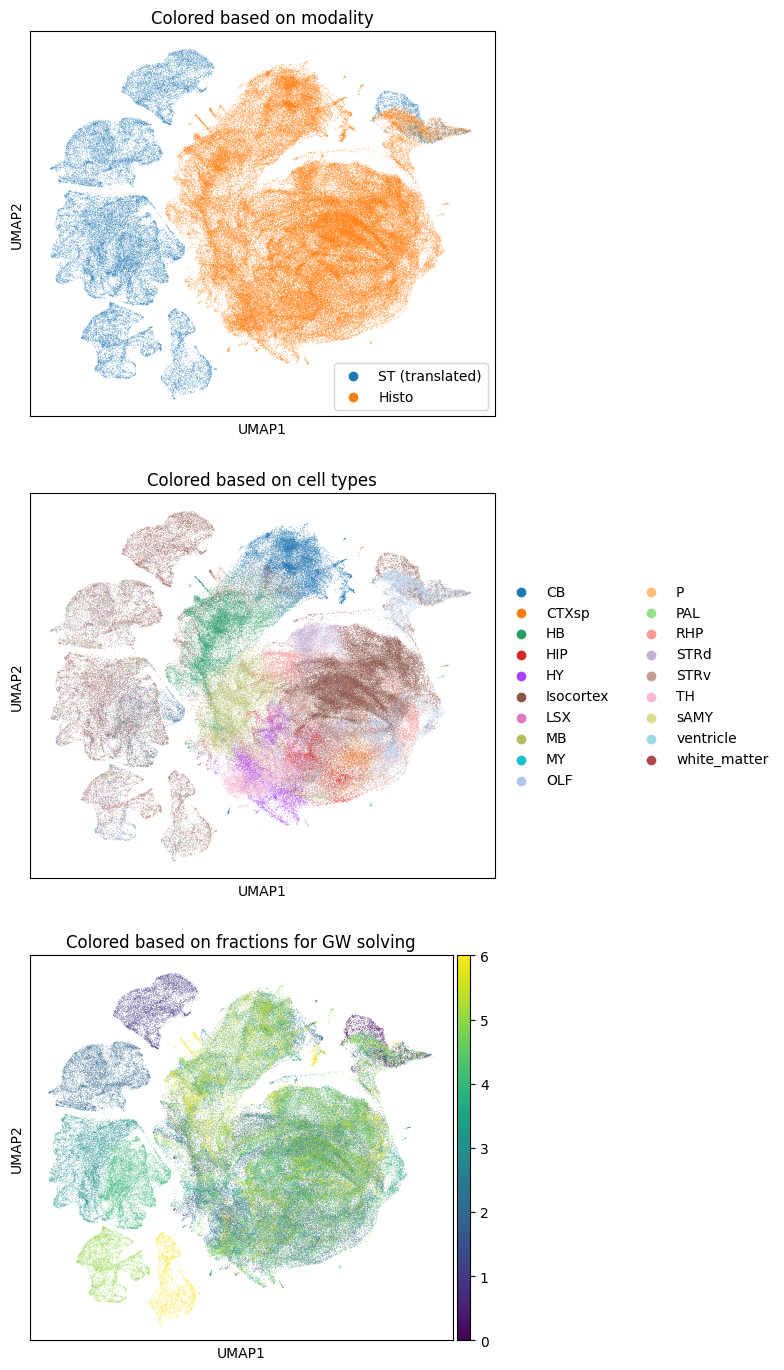

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 17))

sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")

sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")

sc.pl.umap(adata, color=["fraction"], ax=ax3, show=False)
ax3.set_title("Colored based on fractions for GW solving")
# plt.tight_layout(pad=3.0)
plt.show()

In [29]:
adata_st.write(os.path.join(translation_path, "adata_st.h5ad"))
adata.write(os.path.join(translation_path, "adata_joined,h5ad"))

### Look at UMAPs per problem and scores

In [4]:
translation_path = "/p/project1/hai_fzj_bda/koenig8/ot/models/largest_model_translations"
adata_st = sc.read_h5ad(os.path.join(translation_path, "adata_st.h5ad"))

In [10]:
adatas = []
for i in tqdm(range(fractions)):
    ad_st = adata_st[adata_st.obs.fraction == i]
    ad_histo = adatas_target[i]
    
    ad = sc.concat(
        [ad_st, ad_histo],
        join="outer",
        label="batch",
        keys=["ST (translated)", "Histo"],
    )
    ad.obsm["X_translated_1"] = np.concatenate(
        (ad_st.obsm["translation"], ad_histo.obsm["uni_embedding"]), axis=0
    )
    sc.pp.neighbors(ad, use_rep="X_translated_1")
    sc.tl.umap(ad)
    adatas.append(ad)
[ad.shape for ad in adatas]

100%|██████████| 7/7 [03:16<00:00, 28.09s/it]


[(7648, 1536),
 (24029, 1536),
 (41452, 1536),
 (52523, 1536),
 (50676, 1536),
 (35877, 1536),
 (28454, 1536)]

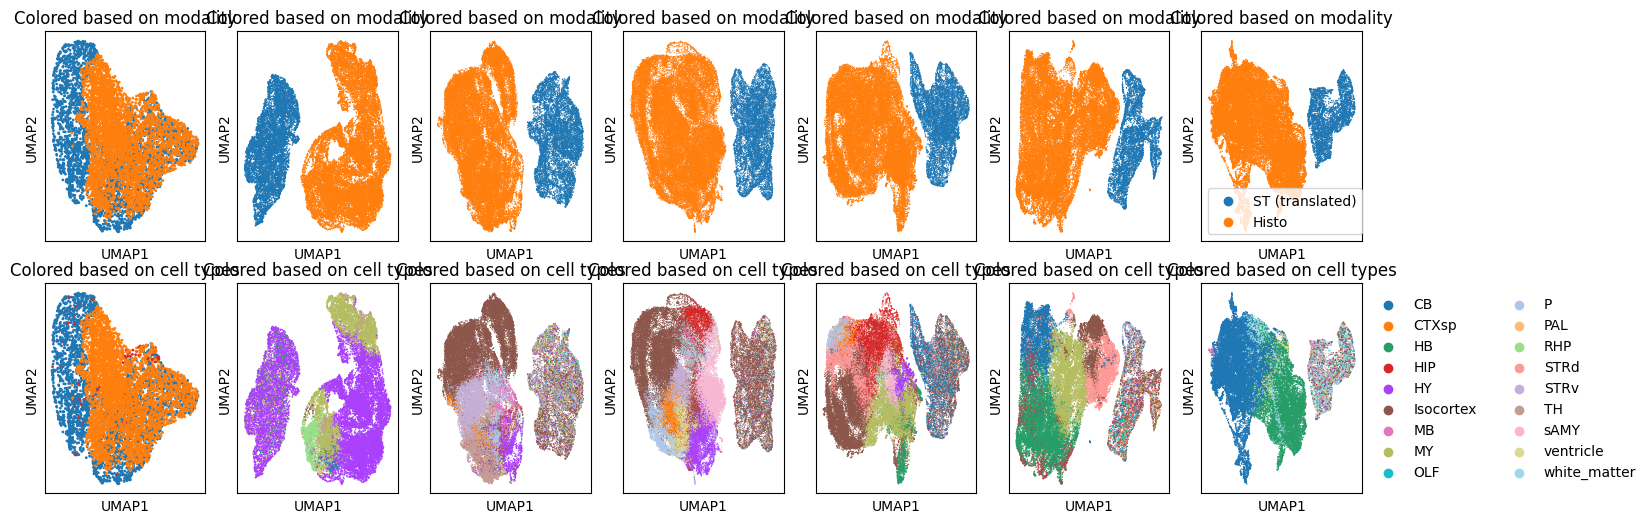

In [17]:
fig, axes = plt.subplots(2, fractions, figsize=(17, 6))

for i in range(fractions):
    ax1, ax2 = axes[0][i], axes[1][i]
    adata = adatas[i]
    sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
    ax1.legend()
    ax1.set_title("Colored based on modality")

    sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False)
    ax2.set_title("Colored based on cell types")

    if i < 6:
        ax1.legend().remove()
        ax2.legend().remove()

plt.show()